# gene report


> Vizualise switching genes and the differences in isoforms expression between different cell types

In [27]:
#| default_exp gene_report

In [32]:
#| hide
#| export
from nbdev.showdoc import *

In [2]:
#| hide 
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import anndata as ad
from matplotlib import pyplot as plt
import seaborn as sns
import patchworklib as pw
import requests
import sys
print(ad.__version__)

/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distanc

0.10.3


<Figure size 100x100 with 0 Axes>

Read adata object from file:

In [3]:
adata_gen = ad.read_h5ad('/data/analysis/data_diamant/brain_mouse/write/brain_mouse_190.h5ad')

In [4]:
path = "/data/analysis/data_diamant/brain_mouse/data/GSM3748087_190c.isoforms.matrix.txt"

In [5]:
#| export
# creates isoform level anndata object from df produced by Sicelore:
def create_iso_adata (path):
    with open(path) as isoforms:
        df = pd.read_table(isoforms, sep='\t')

    counts = df.iloc[0:,2:]
    adata_iso = ad.AnnData(counts).transpose()
    adata_iso.var_names = df['transcriptId'].to_list()
    adata_iso.var = df[['transcriptId', 'geneId']]
    barcodes = {'barcodes': df.columns.values[2:]}   
    barcodes = pd.DataFrame(data=barcodes)
    adata_iso.obs = barcodes
    adata_iso.obs_names = barcodes['barcodes'].tolist()
    return(adata_iso)

Let's create an isoform level ann data object:

In [6]:
adata_iso = create_iso_adata(path)

In [7]:
# create mdata object which storres anndata with isoforms counts and anndata with gene counts:
mdata = mu.MuData({'gen': adata_gen, 'iso': adata_iso})


The function _plot_switch_gen_bar is the internal function that plots the number of transcripts and number of genes and shows which percentage of genes are expressed by multiple isoforms. It can be used on its own under the name plot_switch_gen_bar

In [8]:
#| export
def _plot_switch_gen_bar (mdata, _ax): 
    if _ax is None:
        fig, ax = plt.subplots()
        mdata.mod['gen'].var['n_of_iso'] = mdata.mod['iso'].var.groupby(by='geneId').count()
        x = ['genes']
        x1 = ['transcripts']
        multiple_iso = sum(mdata.mod['gen'].var['n_of_iso'] > 1)
        mono_iso = sum((mdata.mod['gen'].var['n_of_iso'] > 1) == False)
        labels = [str(round(1000*multiple_iso/(multiple_iso+mono_iso))/10) + '%', str(round(1000*mono_iso/(multiple_iso+mono_iso))/10) + '%']
        mult = ax.bar(x, multiple_iso, color = 'deepskyblue', label=labels[1]) #multiple_iso/(multiple_iso+mono_iso))
        mono = ax.bar(x, mono_iso, bottom=multiple_iso, color='sandybrown', label=labels[0]) #mona_iso/(multiple_iso+mono_iso))
        tran = ax.bar(x1, len(mdata.mod['iso'].var['transcriptId']))
        ax.text(
            ax.patches[0].get_x() + ax.patches[0].get_width() / 2, ax.patches[0].get_height() / 2, labels[0], ha="center", va="center"
        )
        ax.text(
            ax.patches[1].get_x() + ax.patches[1].get_width() / 2, ax.patches[1].get_height() / 2 + ax.patches[0].get_height(), labels[1], ha="center", va="center"
        )
        plt.legend(['Multiple isoforms', 'Single isoform'])
        plt.show()
    else:
        mdata.mod['gen'].var['n_of_iso'] = mdata.mod['iso'].var.groupby(by='geneId').count()
        x = ['genes']
        x1 = ['transcripts']
        multiple_iso = sum(mdata.mod['gen'].var['n_of_iso'] > 1)
        mono_iso = sum((mdata.mod['gen'].var['n_of_iso'] > 1) == False)
        labels = [str(round(1000*multiple_iso/(multiple_iso+mono_iso))/10) + '%', str(round(1000*mono_iso/(multiple_iso+mono_iso))/10) + '%']
        mult = _ax.bar(x, multiple_iso, color = 'deepskyblue', label=labels[1]) #multiple_iso/(multiple_iso+mono_iso))
        mono = _ax.bar(x, mono_iso, bottom=multiple_iso, color='sandybrown', label=labels[0]) #mona_iso/(multiple_iso+mono_iso))
        tran = _ax.bar(x1, len(mdata.mod['iso'].var['transcriptId']))
        _ax.text(
            _ax.patches[0].get_x() + _ax.patches[0].get_width() / 2, _ax.patches[0].get_height() / 2, labels[0], ha="center", va="center"
        )
        _ax.text(
            _ax.patches[1].get_x() + _ax.patches[1].get_width() / 2, _ax.patches[1].get_height() / 2 + _ax.patches[0].get_height(), labels[1], ha="center", va="center"
        )
        _ax.legend(['Multiple isoforms', 'Single isoform'])
def plot_switch_gen_bar (mdata): # takes as input mdata object
    _plot_switch_gen_bar (mdata, None)

    

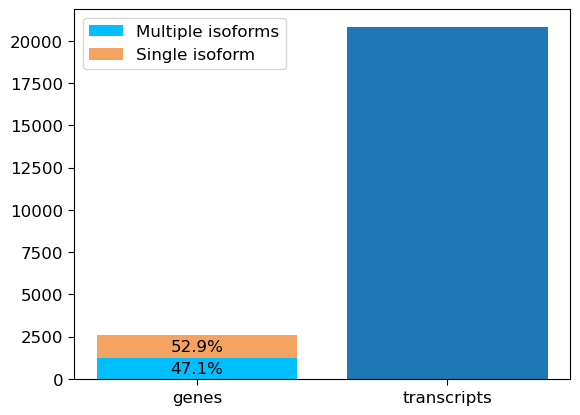

In [77]:
plot_switch_gen_bar(mdata)

Plot_isoforms_frequencies is a function that takes as input mdata object and plots the 

In [9]:
#| export
# count total frequencis of genes having 1 , 2 , 3 , ... n isoforms
def _plot_isoforms_frequencies (mdata, _ax):
    if _ax is None:
        fig, ax = plt.subplots()
        mdata.mod['gen'].var['n_of_iso'].value_counts().plot(ax=ax, kind='bar', 
                                                             xlabel='number of isoforms per gene', ylabel='quantity of genes')
    else:
        mdata.mod['gen'].var['n_of_iso'].value_counts().plot(ax=_ax, kind='bar', 
                                                             xlabel='number of isoforms per gene', ylabel='quantity of genes')
def plot_isoforms_frequencies(mdata): # takes as input mdata object with anndata on gene and anndata on isoform levels 
    _plot_isoforms_frequencies(mdata, None)

In [14]:
# number of cells in each cluster:
mdata.mod['gen'].obs.groupby(by ='leiden').count()

,barcodes
leiden,
Radial glia,38
Imature glutamatergic,28
Mature glutamatergic,27
Imature GABAergic,26
Cajal Retzius,26
Cycling Radial glia,20
mature GABAergic,20
intermediate progenitor,5


## Prepare mdata object:

In [15]:
# copy cell types labels identified on genes to isoform matrix:
adata_gen.obs["cell_type"] = pd.Categorical(adata_gen.obs['leiden'].to_list())
mdata.mod['iso'].obs['cell_type'] = mdata.mod['gen'].obs['cell_type']

In [16]:
#| export
# boxplot with number of genes expressed per cell type:
def _plot_genes_cell_type (mdata, _ax): #mdata with annotated cell types in isoform and gen anndata objects
    if _ax is None:
        df = pd.DataFrame(np.transpose(mdata.mod['iso'].X), columns=mdata.mod['iso'].obs['cell_type'])
        df = df.sum(axis = 0).to_frame().reset_index()
        df.columns = ['cell_type', 'n_of_genes']
        ax = sns.boxplot(x='cell_type', y='n_of_genes', data=df) 
        ax1 = sns.stripplot(x='cell_type', y='n_of_genes', data=df, color = 'black', size = 3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()
    else:
        df = pd.DataFrame(np.transpose(mdata.mod['iso'].X), columns=mdata.mod['iso'].obs['cell_type'])
        df = df.sum(axis = 0).to_frame().reset_index()
        df.columns = ['cell_type', 'n_of_genes']
        sns.boxplot(x='cell_type', y='n_of_genes', data=df, ax=_ax) 
        sns.stripplot(x='cell_type', y='n_of_genes', data=df, color = 'black', size = 3, ax=_ax)
        _ax.set_xticklabels(_ax.get_xticklabels(), rotation=90)

def plot_genes_cell_type(mdata):
    _plot_genes_cell_type(mdata, None)

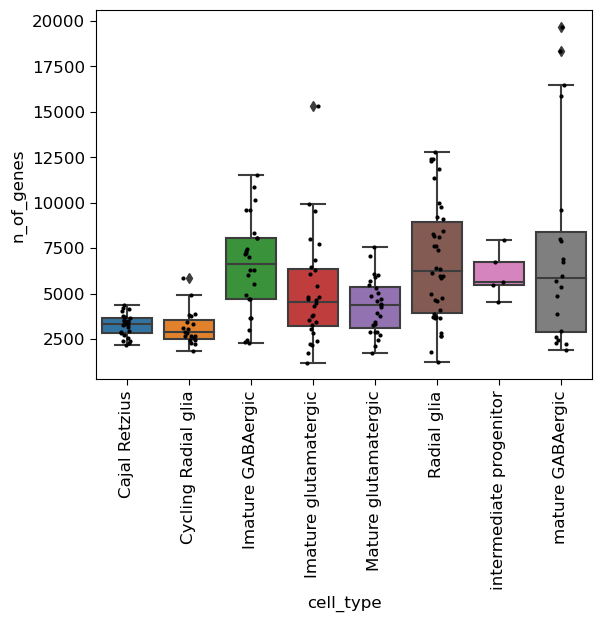

In [17]:
plot_genes_cell_type(mdata)

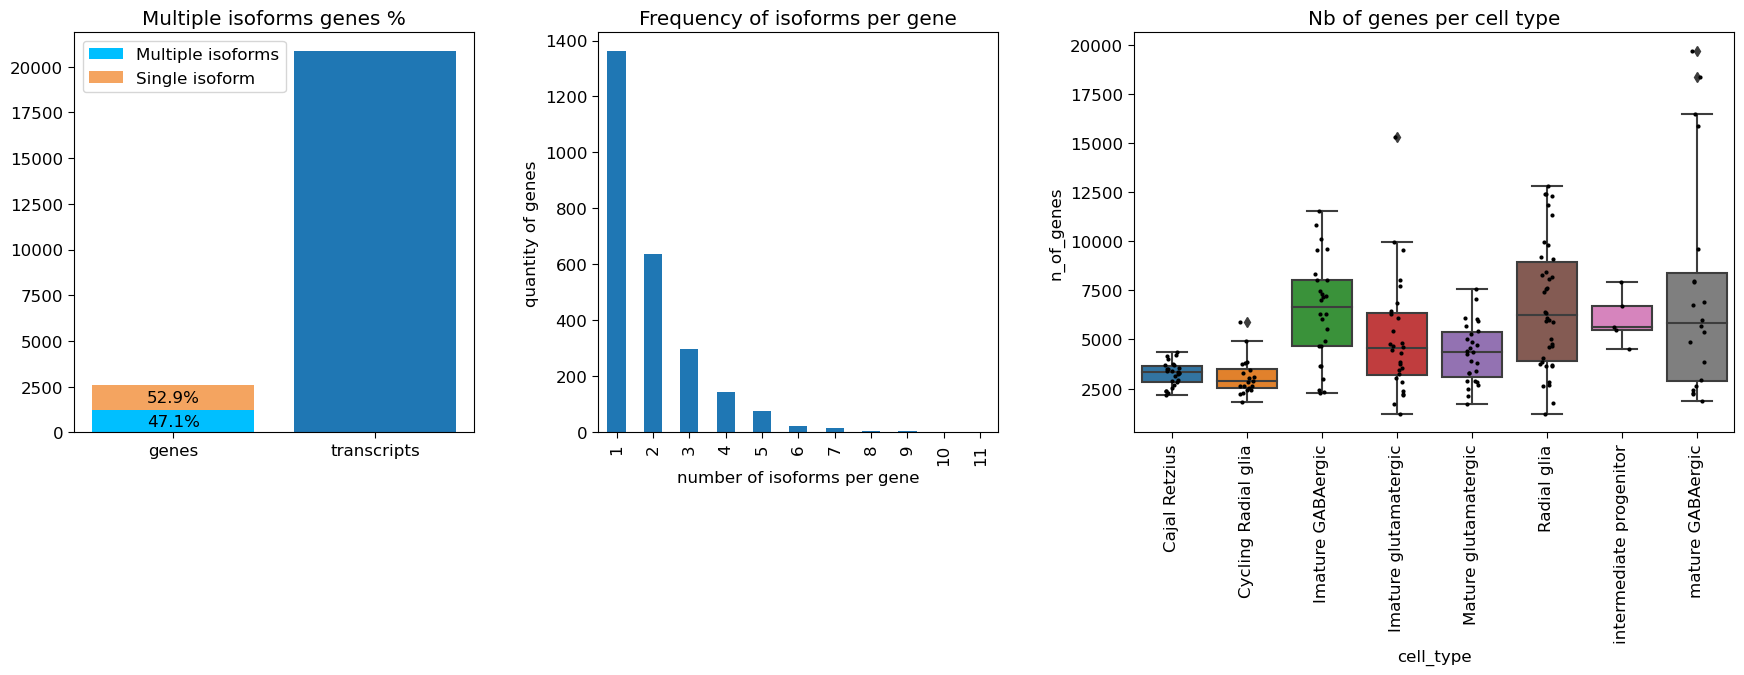

In [18]:
#| export
def plot_isoforms_summary(mdata):
    ax1 = pw.Brick(figsize=(4,4))
    _plot_switch_gen_bar(mdata, ax1)
    ax1.set_title("Multiple isoforms genes %")
    ax2 = pw.Brick(figsize=(4,4))
    _plot_isoforms_frequencies(mdata, ax2)
    ax2.set_title("Frequency of isoforms per gene")
    ax3 = pw.Brick(figsize=(3,2))
    _plot_genes_cell_type(mdata, ax3)
    ax3.set_title("Nb of genes per cell type")
    return (ax1|ax2|ax3).savefig()
plot_isoforms_summary(mdata)

In [19]:
# | hide
df = mdata.mod['iso'].to_df().sum(axis = 1)
#df.set_index(mdata.mod['iso'].obs['cell_type'])
df


CAACTAGAGCTGTTCA     3862
CCACCTACAAAGTCAA     3695
AACCATGAGACCACGA     7944
GATGAGGTCGACCAGC     3424
GCACTCTTCTATCGCC     6081
                    ...  
AAGACCTAGATTACCC     6446
CTGAAGTAGGTAGCTG    16474
TAGTGGTAGGCCCTTG     1707
GATGAAAAGCAATATG    12417
TTCTTAGTCTGTTGAG     9982
Length: 190, dtype: int64

### Reduce the gene matrix to switching genes (gens that are expressed by more then one isoform)

In [20]:
mdata.mod['gen'].var['n_of_iso']


geneId
1110020A21Rik    1
2310039H08Rik    1
2810403A07Rik    3
3100002H09Rik    1
3110070M22Rik    1
                ..
Zswim1           1
Zswim4           1
Zzz3             5
mt-Atp6          1
mt-Nd2           1
Name: n_of_iso, Length: 2574, dtype: int64

### Filter mdata object to leave switching genes only

In [21]:
#| export
# subset mdata object for switching genes
def filter_mdata (mdata):
    gene_m = mdata.mod['gen'][:, mdata.mod['gen'].var['n_of_iso'] > 1]
    gene_iso_m = mdata.mod['iso'][:, mdata.mod['iso'].var['geneId'].isin(gene_m.var.index)]
    mdata_m = mu.MuData({'gen': gene_m, 'iso': gene_iso_m})
    return mdata_m

In [88]:
filtered_m = filter_mdata(mdata)



In [22]:
class mdata_m(mu.MuData):
    def __create_iso_adata (self, path):
        with open(path) as isoforms:
            df = pd.read_table(isoforms, sep='\t')

        counts = df.iloc[0:,2:]
        adata_iso = ad.AnnData(counts).transpose()
        adata_iso.var_names = df['transcriptId'].to_list()
        adata_iso.var = df[['transcriptId', 'geneId']]
        barcodes = {'barcodes': df.columns.values[2:]}   
        barcodes = pd.DataFrame(data=barcodes)
        adata_iso.obs = barcodes
        adata_iso.obs_names = barcodes['barcodes'].tolist()
        return adata_iso
    def __filter_mdata (self):
        ##
        gene_m = self.mod['gen'][:, self.mod['gen'].var['n_of_iso'] > 1]
        gene_iso_m = self.mod['iso'][:, self.mod['iso'].var['geneId'].isin(gene_m.var.index)]
        mdata_m = mu.MuData({'gen': gene_m, 'iso': gene_iso_m})
        return mdata_m
    
    
    def iso_percent(self, df, barcodes_regex="^[ACGT]+$"):
        iso_perc_df = df.__deepcopy__()
        if len(iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()) < 1:
            raise ValueError("No barcode was identified. Please check the names of the columns.")
        iso_perc_df[iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()] = iso_perc_df.filter(regex=(barcodes_regex)) / iso_perc_df.groupby(['geneId']).transform('sum').filter(regex=(barcodes_regex))
        iso_perc_df = iso_perc_df.replace(np.nan, 0.0)
        return iso_perc_df
        
    def __init__(self, path_isoforms, path_genome):
        adata_gen = ad.read_h5ad(path_genome)
        adata_gen.obs["cell_type"] = pd.Categorical(adata_gen.obs['leiden'].to_list())
        super().__init__({'gen': adata_gen, 'iso': self.__create_iso_adata(path_isoforms)})
        self.mod['gen'].var['n_of_iso'] = self.mod['iso'].var.groupby(by='geneId').count()
        self.mod['iso'].obs['cell_type'] = self.mod['gen'].obs['cell_type']
        self.__filtered_mdata = self.__filter_mdata()
        df = self.__filtered_mdata.mod['iso'].to_df().set_index(self.__filtered_mdata.mod['iso'].obs['barcodes'])
        df = df.transpose() 
        df[['transcriptId', 'geneId']] = self.__filtered_mdata.mod['iso'].var
        df_m_iso = self.iso_percent(df)
        df_m_iso = df_m_iso.iloc[0:,:-2].transpose()
        self.__filtered_mdata.mod['iso'].obsm['Iso_prct'] = df_m_iso

    def plot_isoforms_summary(self):
        ax1 = pw.Brick(figsize=(4,4))
        self._plot_switch_gen_bar(ax1)
        ax1.set_title("Multiple isoforms genes %")
        ax2 = pw.Brick(figsize=(4,4))
        self._plot_isoforms_frequencies(ax2)
        ax2.set_title("Frequency of isoforms per gene")
        ax3 = pw.Brick(figsize=(3,2))
        self._plot_genes_cell_type(ax3)
        ax3.set_title("Nb of genes per cell type")
        return (ax1|ax2|ax3).savefig()

    def _plot_genes_cell_type (self, _ax): #mdata with annotated cell types in isoform and gen anndata objects
        if _ax is None:
            df = pd.DataFrame(np.transpose(self.mod['iso'].X), columns=self.mod['iso'].obs['cell_type'])
            df = df.sum(axis = 0).to_frame().reset_index()
            df.columns = ['cell_type', 'n_of_genes']
            ax = sns.boxplot(x='cell_type', y='n_of_genes', data=df) 
            ax1 = sns.stripplot(x='cell_type', y='n_of_genes', data=df, color = 'black', size = 3)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()
        else:
            df = pd.DataFrame(np.transpose(self.mod['iso'].X), columns=self.mod['iso'].obs['cell_type'])
            df = df.sum(axis = 0).to_frame().reset_index()
            df.columns = ['cell_type', 'n_of_genes']
            sns.boxplot(x='cell_type', y='n_of_genes', data=df, ax=_ax) 
            sns.stripplot(x='cell_type', y='n_of_genes', data=df, color = 'black', size = 3, ax=_ax)
            _ax.set_xticklabels(_ax.get_xticklabels(), rotation=90)

    def plot_genes_cell_type(self):
        self._plot_genes_cell_type(None)
    
    def _plot_isoforms_frequencies (self, _ax):
        if _ax is None:
            fig, ax = plt.subplots()
            self.mod['gen'].var['n_of_iso'].value_counts().plot(ax=ax, kind='bar', 
                                                                xlabel='number of isoforms per gene', ylabel='quantity of genes')
        else:
            self.mod['gen'].var['n_of_iso'].value_counts().plot(ax=_ax, kind='bar', 
                                                                xlabel='number of isoforms per gene', ylabel='quantity of genes')
    def plot_isoforms_frequencies(self):
        self._plot_isoforms_frequencies(None)

    def _plot_switch_gen_bar (self, _ax):
        if _ax is None:
            fig, ax = plt.subplots()
            x = ['genes']
            x1 = ['transcripts']
            multiple_iso = sum(self.mod['gen'].var['n_of_iso'] > 1)
            mono_iso = sum((self.mod['gen'].var['n_of_iso'] > 1) == False)
            labels = [str(round(1000*multiple_iso/(multiple_iso+mono_iso))/10) + '%', str(round(1000*mono_iso/(multiple_iso+mono_iso))/10) + '%']
            mult = ax.bar(x, multiple_iso, color = 'deepskyblue', label=labels[1]) #multiple_iso/(multiple_iso+mono_iso))
            mono = ax.bar(x, mono_iso, bottom=multiple_iso, color='sandybrown', label=labels[0]) #mona_iso/(multiple_iso+mono_iso))
            tran = ax.bar(x1, len(self.mod['iso'].var['transcriptId']))
            ax.text(
                ax.patches[0].get_x() + ax.patches[0].get_width() / 2, ax.patches[0].get_height() / 2, labels[0], ha="center", va="center"
            )
            ax.text(
                ax.patches[1].get_x() + ax.patches[1].get_width() / 2, ax.patches[1].get_height() / 2 + ax.patches[0].get_height(), labels[1], ha="center", va="center"
            )
            plt.legend(['Multiple isoforms', 'Single isoform'])
            plt.show()
        else:
            x = ['genes']
            x1 = ['transcripts']
            multiple_iso = sum(self.mod['gen'].var['n_of_iso'] > 1)
            mono_iso = sum((self.mod['gen'].var['n_of_iso'] > 1) == False)
            labels = [str(round(1000*multiple_iso/(multiple_iso+mono_iso))/10) + '%', str(round(1000*mono_iso/(multiple_iso+mono_iso))/10) + '%']
            mult = _ax.bar(x, multiple_iso, color = 'deepskyblue', label=labels[1]) #multiple_iso/(multiple_iso+mono_iso))
            mono = _ax.bar(x, mono_iso, bottom=multiple_iso, color='sandybrown', label=labels[0]) #mona_iso/(multiple_iso+mono_iso))
            tran = _ax.bar(x1, len(self.mod['iso'].var['transcriptId']))
            _ax.text(
                _ax.patches[0].get_x() + _ax.patches[0].get_width() / 2, _ax.patches[0].get_height() / 2, labels[0], ha="center", va="center"
            )
            _ax.text(
                _ax.patches[1].get_x() + _ax.patches[1].get_width() / 2, _ax.patches[1].get_height() / 2 + _ax.patches[0].get_height(), labels[1], ha="center", va="center"
            )
            _ax.legend(['Multiple isoforms', 'Single isoform'])
    
    def plot_switch_gen_bar (self):
        self._plot_switch_gen_bar (None)

    def plot_transcripts_per_cell_type(self, gene_name):
        grouped = self.__filtered_mdata.mod['iso'].obsm['Iso_prct']
        grouped['cell_type'] = self.mod['iso'].obs['cell_type']
        res = grouped.groupby('cell_type').mean().transpose()
        res = res.assign(transcriptId=self.__filtered_mdata.mod['iso'].var['transcriptId'].to_list())
        res = res.assign(geneId=self.__filtered_mdata.mod['iso'].var['geneId'].to_list())
        res = res[res['geneId'] == gene_name].drop(['geneId'], axis=1)
        plot_data = res.set_index('transcriptId').transpose()
        plot_data.plot(kind='barh', stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 1.0))
    
    def trsct_counts_cell_type (self, gene_name):
        # create df with filtered isoform counts and labeled cell types:
        df = self.__filtered_mdata.mod['iso'].to_df().set_index(self.__filtered_mdata.mod['iso'].obs['cell_type'])
        df = df.transpose() 
        df[['transcriptId', 'geneId']] = self.__filtered_mdata.mod['iso'].var
        gene_iso_count = df[df['geneId']== gene_name]
        gene_iso_count = gene_iso_count.drop('geneId', axis=1).set_index('transcriptId').transpose()
        gene_iso_count_long = gene_iso_count.reset_index().melt(id_vars='cell_type', var_name='transcriptId', value_name='count')
        g = sns.catplot(x="cell_type", y="count", col="transcriptId", aspect=1, dodge=False, kind="violin", data=gene_iso_count_long)
        # Set custom facet titles
        g.set_titles(col_template="{col_name}", size = 8)
        # Remove x ticks
        g.set_xticklabels(rotation=90)
        g.fig.suptitle(gene_name)
        plt.show()

    def __get_coord_from_tscrpt_id(self, transcript_id):
        if '.' in transcript_id:
            transcript_id = transcript_id.split('.')[0]
        server = "https://rest.ensembl.org"
        ext = "/lookup/id/" + transcript_id + "?expand=1"
    
        r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    
        if not r.ok:
            r.raise_for_status()
            sys.exit()
    
        decoded = r.json()
        exon_list = list(decoded['Exon'])
        exon_coord = []
        for i, e in enumerate(exon_list):
            coord = [e.get('end'), e.get('start')]
            exon_coord.append(coord)
        strand = decoded['strand']
        return(exon_coord, strand)

    def __draw_exons(self, exons, direction, color, transcript_name, offset=0, start_override=None, end_override=None, no_render=False):
        if not no_render:
            plt.axes()
            plt.xlim((-0.1, 1))
            plt.ylim((-0.3, 0.3))
            plt.margins(0.2)
            plt.axis('off')
            fig = plt.gcf()
            fig.set_size_inches(20, 2)
        height = 0.2
        plt.plot([offset + 0.1, offset + 0.1], linestyle='solid', linewidth=0.5, c='grey')
        j = 0
        k = 1
        if direction == 1:
            pos_start = exons[0][1]
            pos_end = exons[-1][0]
        else: #direction == -1
            pos_start = exons[-1][1]
            pos_end = exons[0][0]
            j = 1
            k = 0
        real_start = pos_start
        real_end = pos_end
        if start_override is not None and end_override is not None:
            pos_start = start_override
            pos_end = end_override
        total_length = pos_end - pos_start
        total_length_with_margin = 1.05 * total_length
        pos_start_with_margin = pos_start - 0.025*total_length
        for i, exon in enumerate(exons):
            rectangle = plt.Rectangle(((exon[j] - pos_start_with_margin)/total_length_with_margin,offset), (exon[k] - exon[j])/total_length_with_margin, height, fc=color,ec="black")
            plt.gca().add_patch(rectangle)
        if i > 0:
            arrow = None
            if direction < 0:
                arrow = plt.arrow(1, offset - height/4, -1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            else:
                arrow = plt.arrow(0, offset - height/4, 1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            plt.gca().add_patch(arrow)
        plt.plot(np.array([0.025 + (real_start - pos_start) / (total_length)/1.05, 0.025 + (real_start - pos_start) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.plot(np.array([1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, 1 - 0.025 - (pos_end - real_end) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.text(0.025 + (real_start - pos_start) / (total_length)/1.05, offset - height/4 - 0.075, real_start, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, offset - height/4 - 0.075, real_end, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1, offset - height, transcript_name, horizontalalignment='right', verticalalignment='top', fontsize=12)
        if not no_render:
            plt.show()
    
    def __get_transcripts_from_gene(self, gene_name):
        elems = self.__filtered_mdata.mod['iso'].var
        return elems[elems['geneId'] == gene_name]['transcriptId'].to_list()

    def __draw_transcripts_list(self, gene_name, _ax, colors=None):
        transcripts_id = self.__get_transcripts_from_gene(gene_name)
        exons = []
        directions = []
        for tr in transcripts_id:
            t, d = self.__get_coord_from_tscrpt_id(tr)
            exons += [t]
            directions += [d]
        if colors is None:
            colors = []
            for i in range(len(exons)):
                colors.append(['lightblue', 'lightgreen', 'orange', 'yellow', 'brown'][i % 5])
        def get_limits(ex, dir):
            start = sys.maxsize
            end = -sys.maxsize
            for (e, d) in zip(ex, dir):
                if d == 1:
                    start = min(start,e[0][1])
                    end = max(end, e[-1][0])
                else:
                    start = min(start,e[-1][1])
                    end = max(end, e[0][0])
            return (start, end)
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons) * 2)
        i = 0
        (start, end) = get_limits(exons, directions)
        for (ex, di, co, name) in zip(exons, directions, colors, transcripts_id):
            self.__draw_exons(ex, di, co, name, offset= -0.5 * i, start_override=start, end_override=end, no_render=True)
            i+=1
        if _ax is None:
            plt.show()
        else: 
            return plt

    def draw_transcripts_list(self, gene_name, colors=None):
        self.__draw_transcripts_list(gene_name, None, colors)

In [33]:
show_doc(mdata_m)

---

### mdata_m

>      mdata_m (path_isoforms, path_genome)

Multimodal data object

MuData represents modalities as collections of AnnData objects
as well as includes multimodal annotations
such as embeddings and neighbours graphs learned jointly
on multiple modalities and generalised sample
and feature metadata tables.

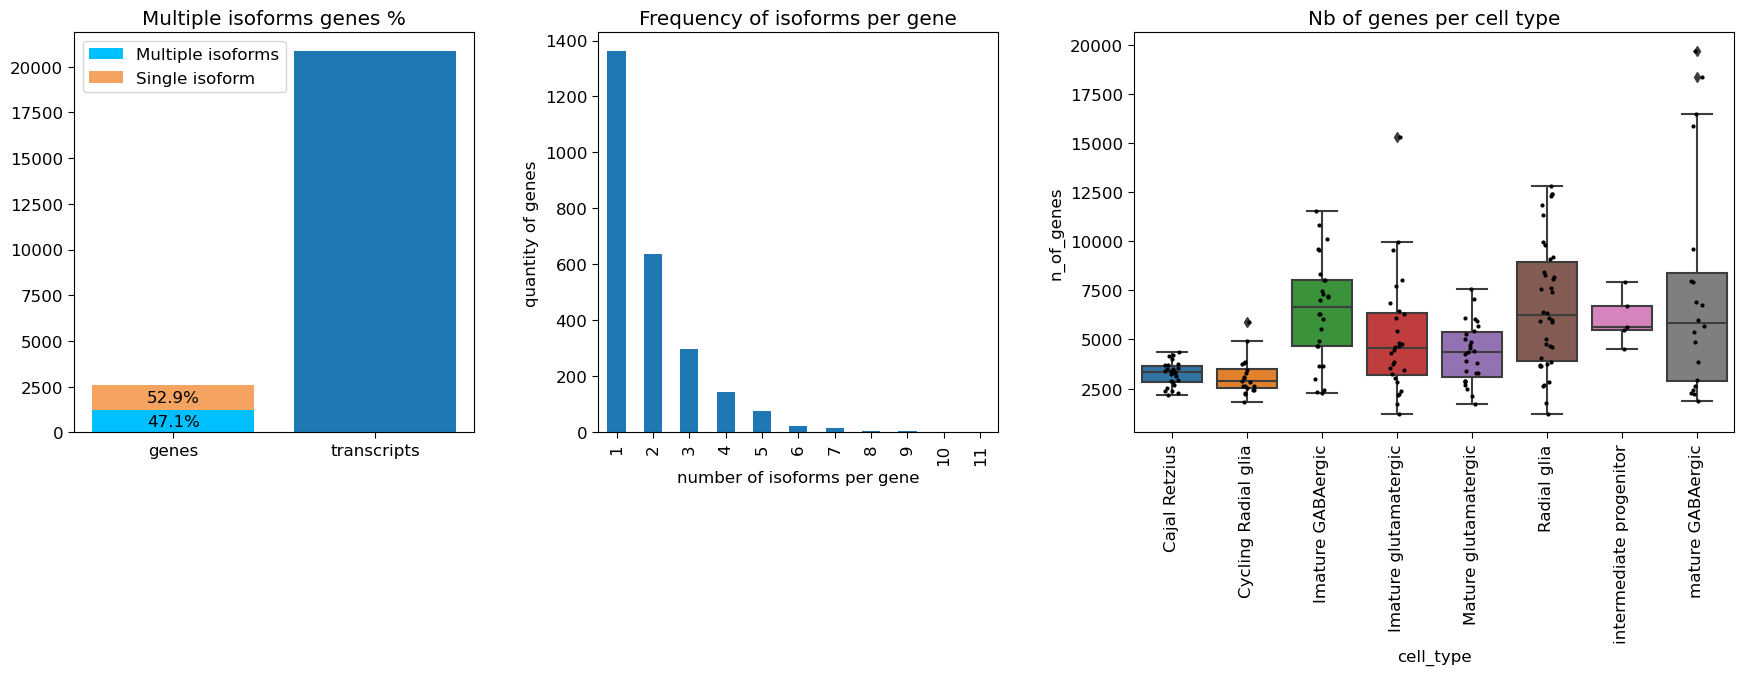

In [90]:
mdata_test = mdata_m(path_isoforms="/data/analysis/data_diamant/brain_mouse/data/GSM3748087_190c.isoforms.matrix.txt", path_genome='/data/analysis/data_diamant/brain_mouse/write/brain_mouse_190.h5ad')
mdata_test.plot_isoforms_summary()



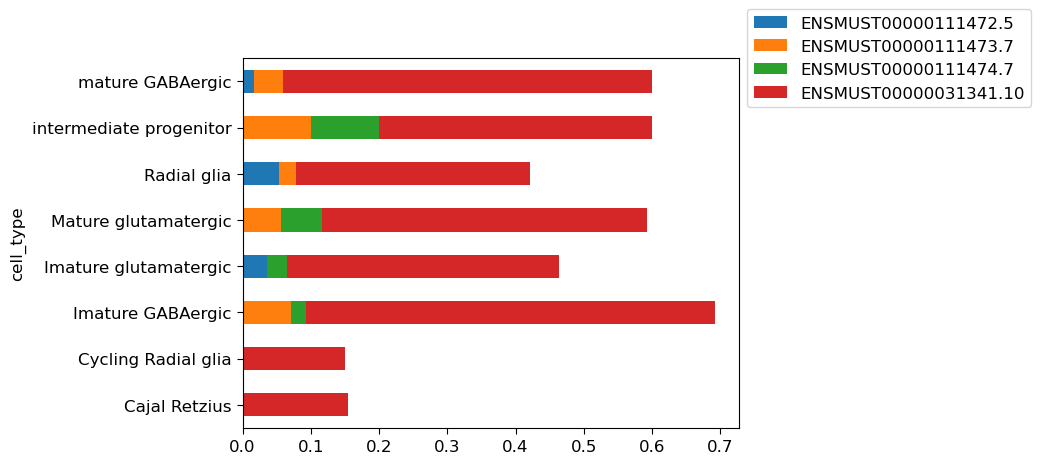

In [91]:
mdata_test.plot_transcripts_per_cell_type('Cdk2ap1')

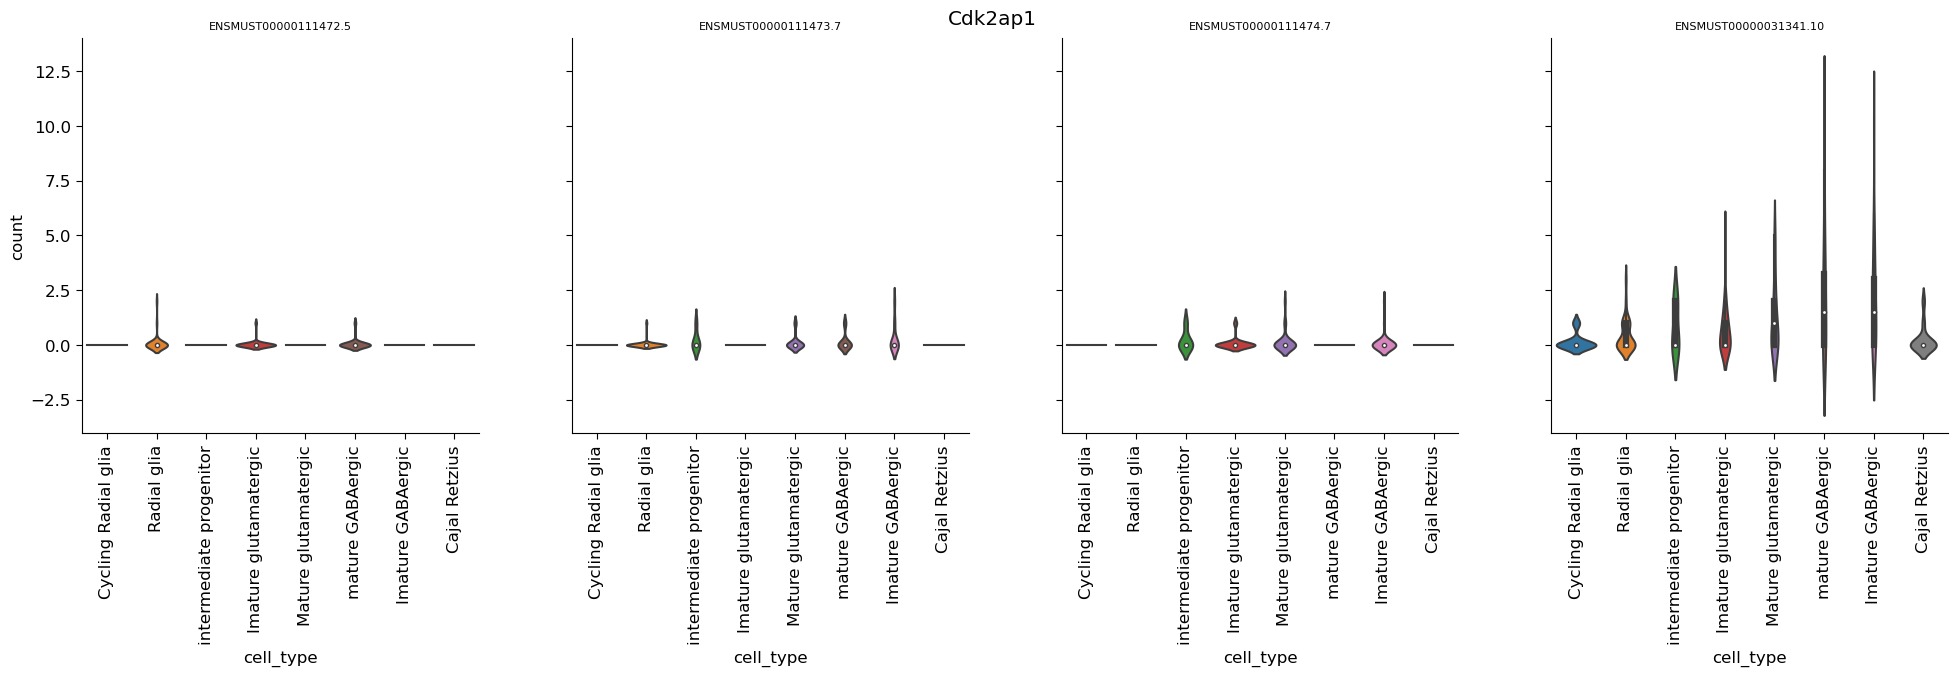

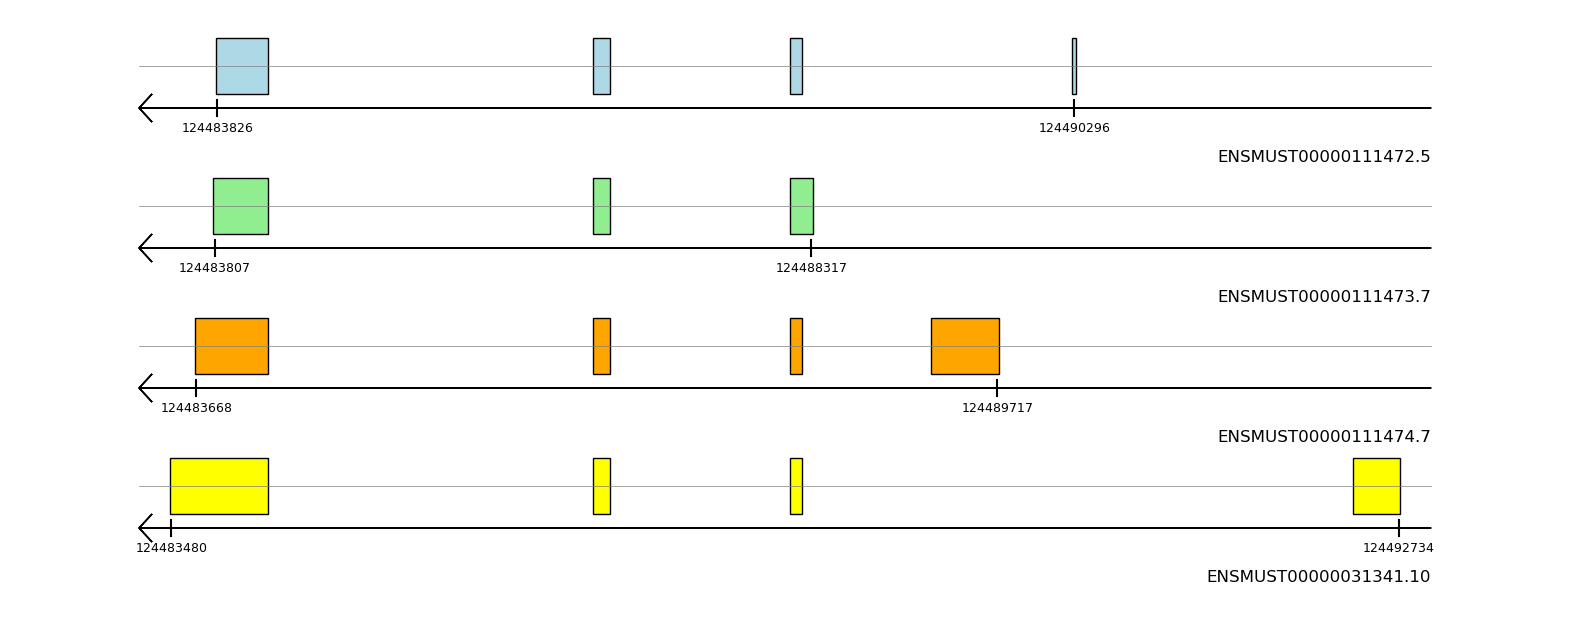

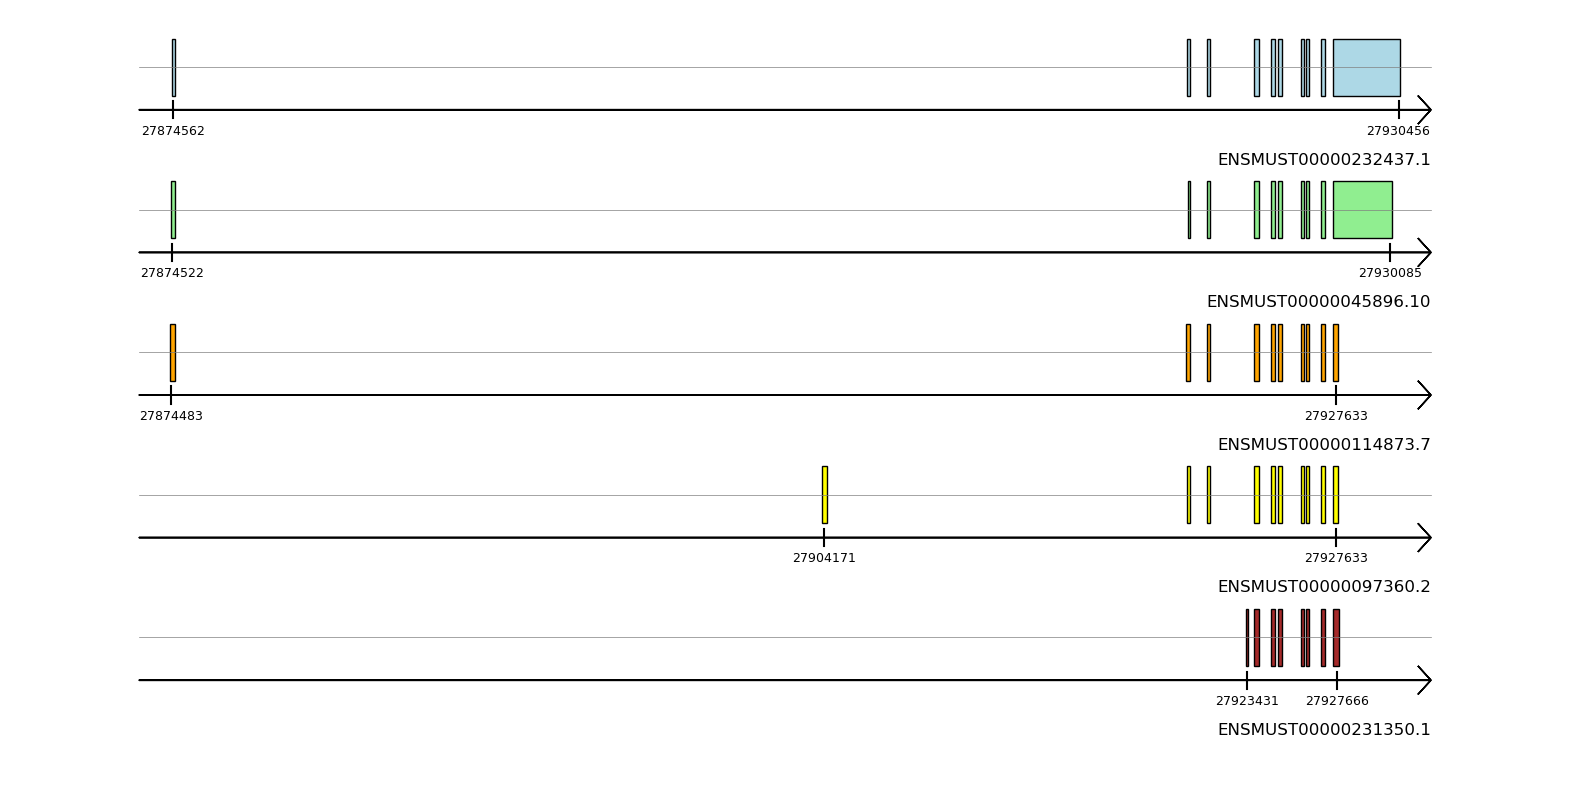

In [92]:
mdata_test.trsct_counts_cell_type('Cdk2ap1')
mdata_test.draw_transcripts_list('Cdk2ap1')
mdata_test.draw_transcripts_list('Pacsin1')

In [93]:
mdata_test

MuData object with n_obs × n_vars = 190 × 23408
  2 modalities
    gen:	190 x 2574
      obs:	'barcodes', 'leiden', 'cell_type'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_of_iso'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    iso:	190 x 20834
      obs:	'barcodes', 'cell_type'
      var:	'transcriptId', 'geneId'

In [94]:
# | hide
# create df with filtered isoform counts and labeled cell types:
df = filtered_m.mod['iso'].to_df().set_index(filtered_m.mod['iso'].obs['barcodes'])
df = df.transpose() 
df[['transcriptId', 'geneId']] = filtered_m.mod['iso'].var
df

barcodes,CAACTAGAGCTGTTCA,CCACCTACAAAGTCAA,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,GTCTCGTTCCTCTAGC,CCATGTCAGTAGATGT,...,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG,transcriptId,geneId
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000231280.1,Eva1c
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000049941.11,Scn3b
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000112655.7,Rpap2
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000139460.1,Top2a
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,ENSMUST00000111472.5,Cdk2ap1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000059339.5,Pnoc
20813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ENSMUST00000231350.1,Pacsin1
20815,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,ENSMUST00000220388.1,Actr6
20816,0,0,0,0,0,2,0,0,0,0,...,0,0,3,1,4,0,1,0,ENSMUST00000069968.12,Pdlim7


Iso_percent is a function that takes as an input a count matrix with gene names and isoforms and count the percentage that every one of isoforms correspond in the total transcript counts from a gene. The output is a dataframe.


In [95]:
#| hide

def iso_percent(input, barcodes_regex="^[ACGT]+$"):
    # df = None
    # def is_df(var):
    #     return var is pd.DataFrame
    # def is_adata(var):
    #     return var is ad.AnnData
    # if is_df(input):
    #     df = input
    # elif is_adata(input):

    iso_perc_df = input.__deepcopy__()
    if len(iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()) < 1:
        raise ValueError("No barcode was identified. Please check the names of the columns.")
    iso_perc_df[iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()] = iso_perc_df.filter(regex=(barcodes_regex)) / iso_perc_df.groupby(['geneId']).transform('sum').filter(regex=(barcodes_regex))
    iso_perc_df = iso_perc_df.replace(np.nan, 0.0)
    return iso_perc_df


In [96]:
#| hide
# Create a matrix with the percentage of isoform from the summ of all the isoforms from the same gene in every cell:
# We impose that barcodes corresponding to cells are all composed of only ACTG capital characters without underscores or any other symbols
def iso_percent(df, barcodes_regex="^[ACGT]+$"):
    iso_perc_df = df.__deepcopy__()
    #if len(iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()) < 1:
    #    raise ValueError("No barcode was identified. Please check the names of the columns.")
    iso_perc_df[iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()] = iso_perc_df.filter(regex=(barcodes_regex)) / iso_perc_df.groupby(['geneId']).transform('sum').filter(regex=(barcodes_regex))
    iso_perc_df = iso_perc_df.replace(np.nan, 0.0)
    return iso_perc_df
df_m_iso = iso_percent(df)
df_m_iso
#df_m_iso = df_m_iso.transpose()
#df_m_iso.colnames = df_m_iso['geneId']
#mdata_test.mod['iso'].obsm['Iso_prct'] = df_m_iso.transpose()
df_m_iso[df_m_iso['geneId']=='Eva1c']

barcodes,CAACTAGAGCTGTTCA,CCACCTACAAAGTCAA,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,GTCTCGTTCCTCTAGC,CCATGTCAGTAGATGT,...,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG,transcriptId,geneId
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000231280.1,Eva1c
14417,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000152223.2,Eva1c
19375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000037539.14,Eva1c


In [97]:
#| hide
#df_m_iso = df_m_iso.set_index('transcriptId')
df_m_iso = df_m_iso.iloc[0:,2:]
df_m_iso

barcodes,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,GTCTCGTTCCTCTAGC,CCATGTCAGTAGATGT,GATCGATGTCAAACTC,GGTGTTAGTTTGCATG,...,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG,transcriptId,geneId
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000231280.1,Eva1c
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000049941.11,Scn3b
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000112655.7,Rpap2
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000139460.1,Top2a
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,ENSMUST00000111472.5,Cdk2ap1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000059339.5,Pnoc
20813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000231350.1,Pacsin1
20815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ENSMUST00000220388.1,Actr6
20816,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,ENSMUST00000069968.12,Pdlim7


Add percentage matrix to mdata object:

In [98]:
#| hide
# filtered_m.mod['iso'].obsm['Iso_prct'] = df_m_iso.transpose()
df_m_iso_tr = df_m_iso.iloc[0:,:-2].transpose()
df_m_iso_tr
filtered_m.mod['iso'].obsm['Iso_prct'] = df_m_iso_tr

ValueError: value.index does not match parent’s axis 0 names:
Index are different

Index length are different
[left]:  188, Index(['AACCATGAGACCACGA', 'GATGAGGTCGACCAGC', 'GCACTCTTCTATCGCC',
       'TGCCCTAAGGCCCGTT', 'TTCGGTCAGCTGGAAC', 'GGATTACAGACGCAAC',
       'GTCTCGTTCCTCTAGC', 'CCATGTCAGTAGATGT', 'GATCGATGTCAAACTC',
       'GGTGTTAGTTTGCATG',
       ...
       'TCGGGACAGCCCAGCT', 'GTTACAGTCTCGATGA', 'ATCATGGAGAAGAAGC',
       'CGCGTTTCAGCTGTAT', 'TTCTTAGAGATCTGCT', 'AAGACCTAGATTACCC',
       'CTGAAGTAGGTAGCTG', 'TAGTGGTAGGCCCTTG', 'GATGAAAAGCAATATG',
       'TTCTTAGTCTGTTGAG'],
      dtype='object', name='barcodes', length=188)
[right]: 190, Index(['CAACTAGAGCTGTTCA', 'CCACCTACAAAGTCAA', 'AACCATGAGACCACGA',
       'GATGAGGTCGACCAGC', 'GCACTCTTCTATCGCC', 'TGCCCTAAGGCCCGTT',
       'TTCGGTCAGCTGGAAC', 'GGATTACAGACGCAAC', 'GTCTCGTTCCTCTAGC',
       'CCATGTCAGTAGATGT',
       ...
       'TCGGGACAGCCCAGCT', 'GTTACAGTCTCGATGA', 'ATCATGGAGAAGAAGC',
       'CGCGTTTCAGCTGTAT', 'TTCTTAGAGATCTGCT', 'AAGACCTAGATTACCC',
       'CTGAAGTAGGTAGCTG', 'TAGTGGTAGGCCCTTG', 'GATGAAAAGCAATATG',
       'TTCTTAGTCTGTTGAG'],
      dtype='object', length=190)

In [ ]:
#| hide
mdata.mod['gen'].obs.groupby(by ='cell_type').count()
def grouped_obs_mean(adata, group_key, layer=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

def get_mean_per_cell_type(geneId, mdata, mod='iso', grouping='cell_type', layer='Iso_prct'):
    grouped = mdata.mod[mod].to_df(layer).groupby(by = grouping)
    


In [ ]:
#| hide
grouped = mdata.mod['iso'].obsm['Iso_prct']
grouped['cell_type'] = mdata.mod['iso'].obs['cell_type']
res = grouped.groupby('cell_type').mean().transpose()
res[['transcriptId', 'geneId']] = df[['transcriptId', 'geneId']]
res[res['geneId'] == 'Stmn1']
plot_data = res[res['geneId'] == 'Stmn1'].set_index('transcriptId').drop(['geneId'], axis=1).transpose()
plot_data.plot(kind='barh', stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 1.0))


KeyError: 'Iso_prct'

Violin plot to compare the quantity of different transcripts between different cell types

In [ ]:
#| hide
gene = "Actr6" #choose gene with multiple isoforms
def trsct_counts_cell_type (gene):
    # create df with filtered isoform counts and labeled cell types:

    df = filtered_m.mod['iso'].to_df().set_index(filtered_m.mod['iso'].obs['cell_type'])
    df = df.transpose() 
    df[['transcriptId', 'geneId']] = filtered_m.mod['iso'].var
    gene_iso_count = df[df['geneId']== gene]
    gene_iso_count = gene_iso_count.drop('geneId', axis=1).set_index('transcriptId').transpose()
    gene_iso_count_long = gene_iso_count.reset_index().melt(id_vars='cell_type', var_name='transcriptId', value_name='count')
    g = sns.catplot(x="cell_type", y="count", col="transcriptId", aspect=0.5, dodge=False, kind="violin", data=gene_iso_count_long)
    # Set custom facet titles
    g.set_titles(col_template="{col_name}", size = 8)
    # Remove x ticks
    g.set_xticklabels(rotation=90)
    g.fig.suptitle(gene)
    plt.show()

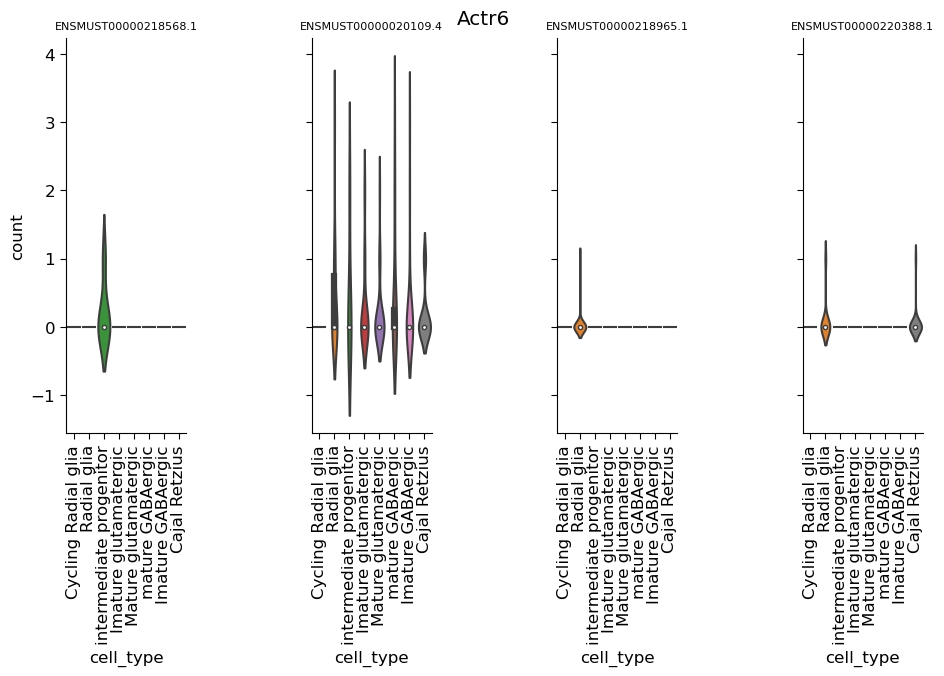

In [ ]:
trsct_counts_cell_type(gene)

Umap showing the expression of transcripts

In [ ]:
# mdata.mod['iso'].obsm['X_umap'] = mdata.mod['gen'].obsm['X_umap'] # not working! should redo Umap for transcripts?


/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


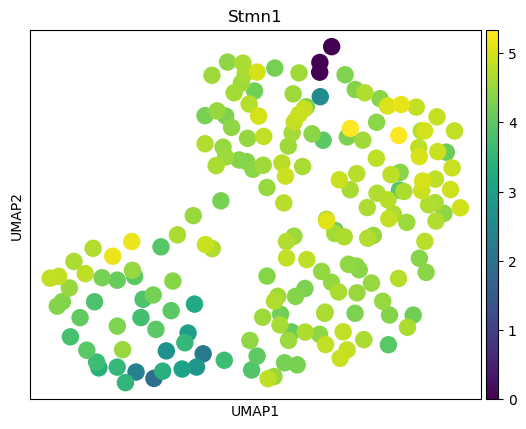

In [ ]:
sc.pl.umap(mdata.mod['gen'], color=["Stmn1"])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()